Алферова Полина, 5030103/10301.




### Чтение данных

In [2]:
import pandas as pd
import numpy as np

#импорт данных
air_reserve = pd.read_csv("air_reserve.csv")
hpg_reserve = pd.read_csv("hpg_reserve.csv")
air_store_info = pd.read_csv("air_store_info.csv")
hpg_store_info = pd.read_csv("hpg_store_info.csv")
store_id_relation = pd.read_csv("store_id_relation.csv")
air_visit_data = pd.read_csv("air_visit_data.csv")
date_info = pd.read_csv("date_info.csv")
sample_submission = pd.read_csv('sample_submission.csv')

data_dict = {
    "air_reserve": air_reserve,
    "hpg_reserve": hpg_reserve,
    "air_store_info": air_store_info,
    "hpg_store_info": hpg_store_info,
    "store_id_relation": store_id_relation,
    "air_visit_data": air_visit_data,
    "date_info": date_info,
    "sample_submission": sample_submission,
}

### Создание датасета для прогнозирования

In [3]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])

#добавление в таблицу air_visit_data таблицы date_info
air_visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')

#удаление дублирующегося столбца calendar_date
air_visit_data = air_visit_data.drop(columns=['calendar_date'])

#добавление в таблицу air_visit_data стоблца month
air_visit_data['month'] = air_visit_data['visit_date'].dt.month
air_visit_data = air_visit_data.merge(air_store_info[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], 
                                      on='air_store_id', how='left')


air_reserve = air_reserve.drop(columns=['reserve_datetime'])

air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime']).dt.date
#суммирование посетителей при совпадении air_store_id и visit_datetime
air_reserve = air_reserve.groupby(['air_store_id', 'visit_datetime'], as_index=False, sort=False)['reserve_visitors'].sum()
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])


air_visit_data = air_visit_data.merge(air_reserve[['air_store_id', 'visit_datetime', 'reserve_visitors']], 
                                      left_on=['air_store_id', 'visit_date'], 
                                      right_on=['air_store_id', 'visit_datetime'], how='left')
air_visit_data = air_visit_data.drop(columns=['visit_datetime'])

# заполним нулями отсутcвующие значения количества посетителей по брони
air_visit_data['reserve_visitors'] = air_visit_data['reserve_visitors'].fillna(0)

air_visit_data = air_visit_data.merge(store_id_relation[['air_store_id', 'hpg_store_id']], on='air_store_id', how='left')
air_visit_data['hpg_store_id'] = air_visit_data['hpg_store_id'].fillna('unknown')

#### Создание таблицы с тестовыми данными

In [4]:
#разделение столбца id в sample_submission на два air_store_id и visit_date
sample_submission['air_store_id'] = sample_submission['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['visit_date'] = sample_submission['id'].apply(lambda x: x.split('_')[-1])
sample_submission['visit_date'] = pd.to_datetime(sample_submission['visit_date'])
sample_submission = sample_submission.drop(columns=['id'])
#перенос столбца visitors в таблице sample_submission в конец
sample_submission['visitors'] = sample_submission.pop('visitors')

sample_submission = sample_submission.merge(date_info, left_on='visit_date', 
                                            right_on='calendar_date', how='left')
sample_submission = sample_submission.drop(columns=['calendar_date'])
sample_submission['month'] = sample_submission['visit_date'].dt.month
sample_submission = sample_submission.merge(air_store_info[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], 
                                            on='air_store_id', how='left')
sample_submission = sample_submission.merge(air_reserve[['air_store_id', 'visit_datetime', 'reserve_visitors']],
                                            left_on=['air_store_id', 'visit_date'],
                                            right_on=['air_store_id', 'visit_datetime'],
                                            how='left')
sample_submission = sample_submission.drop(columns=['visit_datetime'])
sample_submission['reserve_visitors'] = sample_submission['reserve_visitors'].fillna(0)
sample_submission = sample_submission.merge(store_id_relation[['air_store_id', 'hpg_store_id']], 
                                            on='air_store_id', how='left')
sample_submission['hpg_store_id'] = sample_submission['hpg_store_id'].fillna('unknown')

### Удаление выбросов

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

cleaned_air_visit_data = pd.DataFrame()

# удаление выбросов по каждому ресторану
for store_id, group in air_visit_data.groupby('air_store_id', as_index=False, sort=False):
    Q1 = group['visitors'].quantile(0.25)
    Q3 = group['visitors'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(0, Q1 - 1.5 * IQR)
    upper_bound = Q3 + 1.5 * IQR
    cleaned_group = group[(group['visitors'] >= lower_bound) & (group['visitors'] <= upper_bound)]
    cleaned_air_visit_data = pd.concat([cleaned_air_visit_data, cleaned_group])

# удаление выбросов для всех ресторанов
Q1_global = cleaned_air_visit_data['visitors'].quantile(0.25)
Q3_global = cleaned_air_visit_data['visitors'].quantile(0.75)
IQR_global = Q3_global - Q1_global
lower_bound_global = max(0, Q1_global - 1.5 * IQR_global)
upper_bound_global = Q3_global + 1.5 * IQR_global
cleaned_air_visit_data = cleaned_air_visit_data[(cleaned_air_visit_data['visitors'] >= lower_bound_global) &
                                                (cleaned_air_visit_data['visitors'] <= upper_bound_global)]
cleaned_air_visit_data.reset_index(drop=True, inplace=True)

### Анализ данных

#### Распределение посетителей

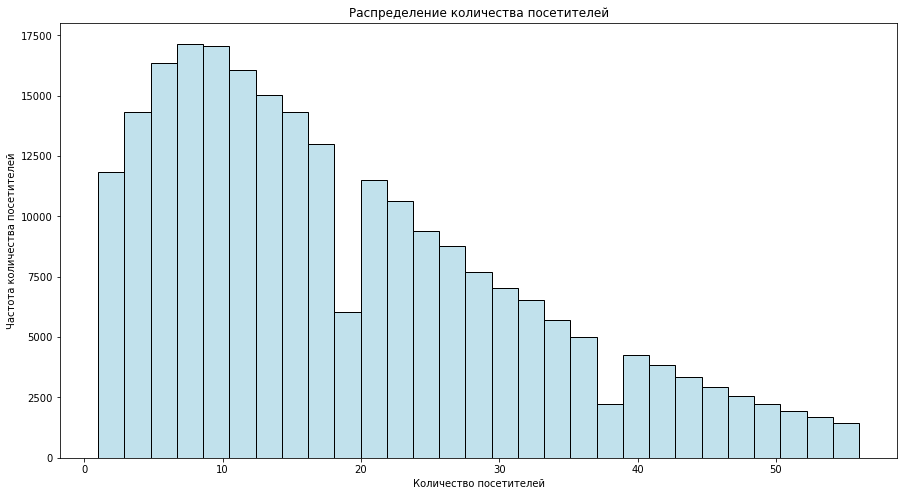

In [6]:
plt.figure(figsize=(15, 8))
sns.histplot(cleaned_air_visit_data['visitors'], bins=29, color='lightblue')

plt.title('Распределение количества посетителей')
plt.xlabel('Количество посетителей')
plt.ylabel('Частота количества посетителей')
plt.show()

#### Среднее количество посeтителей по дням недели

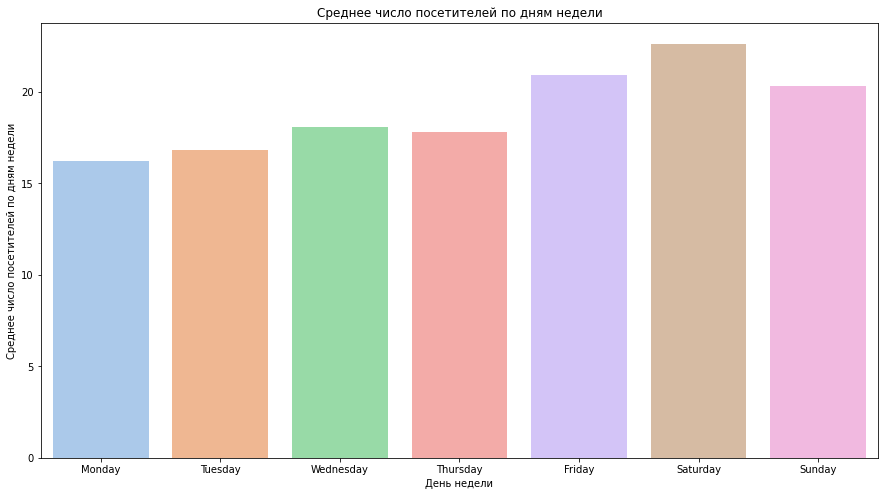

In [7]:
visitors_by_day = cleaned_air_visit_data.groupby('day_of_week', sort=False)['visitors'].mean()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(15, 8))
sns.barplot(x='day_of_week', y='visitors', data=visitors_by_day.reset_index(), order=days, palette='pastel')
plt.title('Среднее число посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее число посетителей по дням недели')
plt.show()

#### Среднее количество посетителей по месяцам

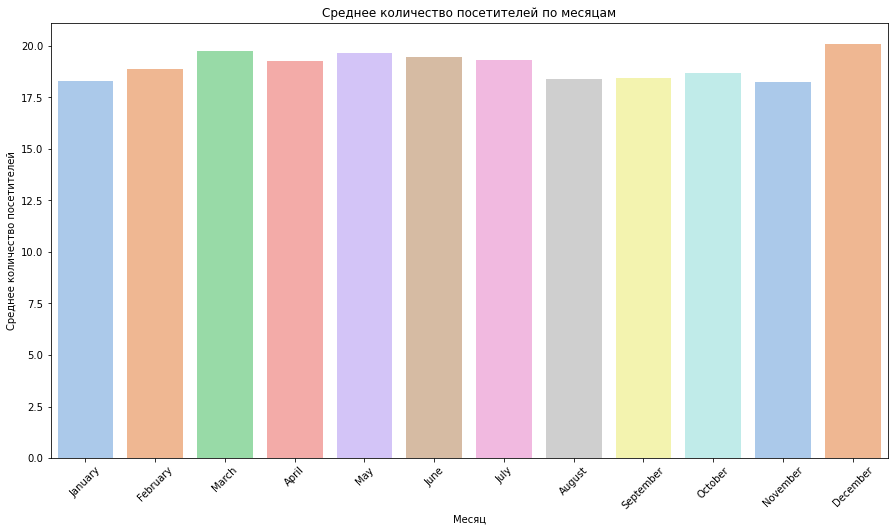

In [8]:
cleaned_air_visit_data['month'] = cleaned_air_visit_data['visit_date'].dt.month

visitors_by_month = cleaned_air_visit_data.groupby('month', sort=False)['visitors'].mean()

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(15, 8))
sns.barplot(x='month', y='visitors', data=visitors_by_month.reset_index(), order=range(1, 13), palette='pastel')
plt.title('Среднее количество посетителей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество посетителей')
plt.xticks(ticks=range(12), labels=months, rotation=45)
plt.legend([], [], frameon=False)
plt.show()


### Выбор признаков и их кодирование

In [9]:
from sklearn.preprocessing import OneHotEncoder

# создание обучающей выборки
cleaned_air_visit_data_encoded = cleaned_air_visit_data.copy().reset_index(drop=True)
cleaned_air_visit_data_merge = cleaned_air_visit_data.copy().reset_index(drop=True) # чтобы в конце NaN и NaT не вышло, индексы не состыкуются

selected_features = cleaned_air_visit_data[['day_of_week', 'holiday_flg', 'month', 'air_genre_name', 'air_area_name', 'hpg_store_id']]

encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(selected_features)
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(selected_features.columns))

cleaned_air_visit_data_encoded = pd.concat([cleaned_air_visit_data_merge, encoded_df], axis=1)
cleaned_air_visit_data_encoded = cleaned_air_visit_data_encoded.drop(columns=['air_store_id', 'visit_date',
                                                                              'visitors', 'day_of_week',
                                                                              'holiday_flg', 'month',
                                                                              'air_genre_name', 'air_area_name',
                                                                              'hpg_store_id'])

# создание тестовой выборки
sample_submission_encoded = sample_submission.copy()

selected_features_test = sample_submission_encoded[['day_of_week', 'holiday_flg', 'month', 'air_genre_name', 'air_area_name', 'hpg_store_id']]

encoded_features_test = encoder.fit_transform(selected_features_test)
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(selected_features_test.columns))

sample_submission_encoded = pd.concat([sample_submission, encoded_df_test], axis=1)
sample_submission_encoded = sample_submission_encoded.drop(columns=['air_store_id', 'visit_date',
                                                                    'visitors', 'day_of_week',
                                                                    'holiday_flg', 'month',
                                                                    'air_genre_name', 'air_area_name',
                                                                    'hpg_store_id'])

#в тестовой выборке два месяца, в обучающей двенадцать, нужно дополнить тестовую выборку до двенадцати месяцев
missing_month_columns = [f'month_{i}' for i in range(1, 13) if f'month_{i}' not in sample_submission_encoded.columns]
for col in missing_month_columns:
    sample_submission_encoded[col] = 0.0

#сделаем одинаковый порядок столбцов в тестовой и обучающей выборке
sample_submission_encoded = sample_submission_encoded[cleaned_air_visit_data_encoded.columns]

### Обучение моделей и подбор гиперпараметров

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
import pandas as pd

#признаки
X_train = cleaned_air_visit_data_encoded 
#целевая величина
y_train = cleaned_air_visit_data['visitors']

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, 
                                                                          test_size=0.3, 
                                                                          random_state=42)

models = {"Linear Regression": LinearRegression(),
          "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)}

gyper_parameters= {"Linear Regression": {},
                   "XGBoost": {'n_estimators': [200],
                            'learning_rate': [0.5],
                                'max_depth': [8]}}

model_scores = {} #сюда записывается MAE
mape_scores = {} #сюда записывается MAPE
for name, model in models.items():
    if gyper_parameters[name]: #если в модели есть гиперпараметры
        grid_search = GridSearchCV(estimator=model, param_grid=gyper_parameters[name])
        grid_search.fit(X_train_split, y_train_split)
        best_model = grid_search.best_estimator_
        y_val_pred = best_model.predict(X_val_split)
    else:
        model.fit(X_train_split, y_train_split)
        y_val_pred = model.predict(X_val_split)
    #нахождение MAE и MAPE
    mae = mean_absolute_error(y_val_split, y_val_pred)
    model_scores[name] = mae

    mape = mean_absolute_percentage_error(y_val_split, y_val_pred)
    mape_scores[name] = mape * 100 

#сортировка ошибок
sorted_scores = sorted(model_scores.items(), key=lambda x: x[1])

print("Средние абсолютные ошибки моделей:")
for model, score in sorted_scores:
    print(f"{model}: MAE = {score:.4f}, MAPE = {mape_scores[model]:.2f}%")

#выбор лучшей модели
best_model_name = sorted_scores[0][0]
best_model = models[best_model_name]

if best_model_name in gyper_parameters and gyper_parameters[best_model_name]:
    best_model = grid_search.best_estimator_

#обучаем лучшую модель на всей обучающей выборке
best_model.fit(X_train, y_train)

#прогнозируем
X_test = sample_submission_encoded
y_test_pred = best_model.predict(X_test)

print("Первые 10 прогнозируемых посетителей:")
print(y_test_pred[:10])

Средние абсолютные ошибки моделей:
XGBoost: MAE = 8.0395, MAPE = 97.86%
Linear Regression: MAE = 9.1255, MAPE = 116.31%
Первые 10 прогнозируемых посетителей:
[11.290783 21.399433 24.771502 27.010246 28.264023 33.178356  8.535947
 11.290783 22.749592 25.273966]
